In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_569210/2906488576.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


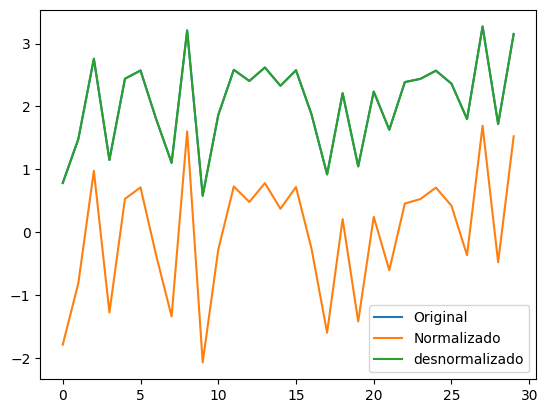

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-25 02:13:47.040753: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:13:47.091054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 02:13:47.091089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 02:13:47.092112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 02:13:47.097510: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:13:47.098034: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-08-25 02:13:47.986061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_9,0.807247,0.519447,0.554041,0.825078,0.080626,0.285277,0.312404,0.065743,0.165096,0.283947,0.611482,0.286156,135.035878,321.425617
model_1_0_8,0.768934,0.493709,0.539940,0.786302,0.096651,0.300556,0.322281,0.080316,0.180838,0.310888,0.534257,0.313307,134.673289,321.063029
model_1_0_7,0.733462,0.483219,0.548846,0.738615,0.111488,0.306784,0.316043,0.098239,0.186903,0.333899,0.462760,0.336497,134.387670,320.777409
model_1_0_6,0.678693,0.446404,0.468133,0.636118,0.134397,0.328639,0.372584,0.136761,0.193951,0.366603,0.352366,0.369456,134.013907,320.403646
model_1_0_5,0.676491,0.442388,0.469269,0.634177,0.135319,0.331023,0.371788,0.137491,0.193179,0.367857,0.347927,0.370720,134.000246,320.389985
model_1_0_4,0.542158,0.384278,0.334329,0.447644,0.191508,0.365519,0.466317,0.207598,0.228212,0.437616,0.077162,0.441022,133.305650,319.695390
model_1_0_3,0.477664,0.358956,0.300883,0.321052,0.218485,0.380551,0.489746,0.255176,0.224312,0.467424,-0.052833,0.471061,133.042078,319.431817
model_1_0_2,0.414606,0.273932,0.306064,0.385414,0.244861,0.431026,0.486116,0.230986,0.290621,0.494834,-0.179935,0.498685,132.814129,319.203868
model_1_0_1,0.253916,0.134828,0.156728,0.216698,0.312075,0.513604,0.590730,0.294397,0.333322,0.558637,-0.503825,0.562984,132.329024,318.718764
model_1_0_0,0.015842,-0.033082,-0.068620,0.018067,0.411658,0.613282,0.748591,0.369050,0.392704,0.641605,-0.983693,0.646599,131.775127,318.164866


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.929924,0.609263,0.579997,0.890531,0.029311,0.231958,0.294221,0.019733,0.099897,0.171206,0.858754,0.172538,137.059552,323.449292
model_1_1_8,0.920777,0.601798,0.574319,0.878284,0.033138,0.236390,0.298199,0.021941,0.105879,0.182038,0.840316,0.183454,136.814167,323.203906
model_1_1_7,0.919236,0.600311,0.572548,0.875715,0.033782,0.237273,0.299439,0.022404,0.106901,0.183800,0.837209,0.185230,136.775626,323.165365
model_1_1_5,0.917956,0.599327,0.567039,0.875562,0.034318,0.237857,0.303298,0.022432,0.108418,0.185251,0.834630,0.186692,136.744183,323.133923
model_1_1_6,0.918042,0.598991,0.570398,0.874493,0.034282,0.238056,0.300945,0.022624,0.107847,0.185153,0.834803,0.186594,136.746285,323.136024
model_1_1_3,0.892085,0.598758,0.607649,0.833809,0.045139,0.238194,0.274850,0.029958,0.117658,0.212460,0.782484,0.214113,136.196015,322.585755
model_1_1_2,0.878389,0.595679,0.601436,0.826711,0.050868,0.240022,0.279202,0.031238,0.128167,0.225539,0.754879,0.227294,135.957052,322.346791
model_1_1_4,0.911169,0.594142,0.548323,0.872942,0.037157,0.240935,0.316409,0.022904,0.113190,0.192761,0.820949,0.194261,136.585218,322.974957
model_1_1_1,0.864499,0.583872,0.600705,0.808439,0.056678,0.247032,0.279715,0.034531,0.135688,0.238071,0.726881,0.239924,135.740743,322.130482
model_1_1_0,0.843625,0.573528,0.595546,0.780509,0.065409,0.253172,0.283329,0.039566,0.145196,0.255752,0.684806,0.257743,135.454184,321.843923


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.973622,0.667925,0.665388,0.975139,0.011033,0.197134,0.234403,0.010799,0.055546,0.105039,0.946833,0.105857,139.013677,325.403416
model_1_2_8,0.969943,0.662198,0.662986,0.971933,0.012572,0.200534,0.236085,0.012191,0.060120,0.112127,0.939416,0.112999,138.752499,325.142238
model_1_2_7,0.969330,0.661456,0.662449,0.971293,0.012829,0.200974,0.236462,0.012470,0.060752,0.113265,0.938180,0.114146,138.712100,325.101839
model_1_2_5,0.963390,0.660697,0.661058,0.964028,0.015313,0.201425,0.237436,0.015625,0.065021,0.123748,0.926208,0.124711,138.358046,324.747785
model_1_2_6,0.964241,0.657731,0.658535,0.965893,0.014957,0.203186,0.239204,0.014815,0.065740,0.122300,0.927923,0.123252,138.405102,324.794841
model_1_2_4,0.962328,0.656165,0.655697,0.964006,0.015758,0.204115,0.241191,0.015635,0.068007,0.125529,0.924068,0.126506,138.300876,324.690616
model_1_2_3,0.956770,0.648316,0.647112,0.957272,0.018082,0.208775,0.247206,0.018560,0.072279,0.134470,0.912865,0.135517,138.025650,324.415389
model_1_2_2,0.953792,0.629996,0.613738,0.957465,0.019328,0.219650,0.270584,0.018476,0.083278,0.139025,0.906862,0.140107,137.892397,324.282136
model_1_2_0,0.937108,0.622436,0.597769,0.938564,0.026307,0.224138,0.281771,0.026686,0.092851,0.162193,0.873234,0.163455,137.275868,323.665607
model_1_2_1,0.944642,0.622363,0.600920,0.947182,0.023155,0.224182,0.279564,0.022943,0.090560,0.152169,0.888420,0.153353,137.531066,323.920806


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.987641,0.687389,0.686546,0.984542,0.005170,0.185579,0.219581,0.007646,0.035621,0.071900,0.975089,0.072459,140.529927,326.919666
model_1_3_6,0.985264,0.683322,0.681939,0.983415,0.006164,0.187994,0.222808,0.008204,0.040184,0.078509,0.970299,0.079120,140.178172,326.567912
model_1_3_7,0.985499,0.682922,0.681291,0.983769,0.006066,0.188231,0.223262,0.008029,0.040209,0.077882,0.970771,0.078488,140.210221,326.599960
model_1_3_8,0.985925,0.682111,0.679197,0.983968,0.005887,0.188713,0.224729,0.007931,0.040164,0.076728,0.971631,0.077325,140.269961,326.659700
model_1_3_3,0.983156,0.681600,0.679889,0.981930,0.007046,0.189016,0.224245,0.008939,0.042928,0.083939,0.966048,0.084592,139.910654,326.300394
model_1_3_5,0.983646,0.681588,0.680436,0.982440,0.006840,0.189023,0.223861,0.008686,0.042555,0.082707,0.967037,0.083351,139.969794,326.359533
model_1_3_4,0.983435,0.681521,0.679882,0.982231,0.006929,0.189063,0.224249,0.008790,0.042750,0.083239,0.966612,0.083887,139.944164,326.333903
model_1_3_2,0.979187,0.676604,0.672122,0.979766,0.008706,0.191982,0.229685,0.010009,0.048267,0.093305,0.958049,0.094031,139.487533,325.877273
model_1_3_1,0.978840,0.676384,0.671985,0.979527,0.008851,0.192113,0.229781,0.010127,0.048656,0.094078,0.957350,0.094810,139.454522,325.844261
model_1_3_0,0.978521,0.676034,0.671859,0.979298,0.008985,0.192320,0.229869,0.010241,0.049076,0.094787,0.956705,0.095524,139.424503,325.814242


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_7,0.992822,0.700632,0.690646,0.986593,0.003003,0.177718,0.216709,0.004715,0.024635,0.054796,0.985531,0.055222,141.616560,328.006299
model_1_4_6,0.992707,0.700447,0.690245,0.986478,0.003051,0.177828,0.216990,0.004756,0.024877,0.055233,0.985299,0.055663,141.584765,327.974504
model_1_4_8,0.993436,0.699976,0.690788,0.987096,0.002746,0.178107,0.216609,0.004538,0.023549,0.052401,0.986768,0.052808,141.795354,328.185093
model_1_4_9,0.993859,0.698777,0.689762,0.987872,0.002568,0.178819,0.217328,0.004265,0.023091,0.050680,0.987623,0.051075,141.928873,328.318612
model_1_4_5,0.992295,0.698232,0.685853,0.985902,0.003223,0.179142,0.220066,0.004958,0.026184,0.056771,0.984469,0.057213,141.474924,327.864663
model_1_4_4,0.991416,0.689220,0.682249,0.986278,0.003591,0.184493,0.222591,0.004826,0.030379,0.059921,0.982698,0.060388,141.258881,327.648620
model_1_4_0,0.987778,0.687431,0.686534,0.981711,0.005112,0.185554,0.219589,0.006432,0.035396,0.071499,0.975366,0.072056,140.552264,326.942003
model_1_4_2,0.989444,0.687241,0.681633,0.983661,0.004416,0.185667,0.223023,0.005746,0.033233,0.066450,0.978722,0.066967,140.845228,327.234967
model_1_4_3,0.989954,0.686229,0.680686,0.984435,0.004202,0.186268,0.223686,0.005474,0.033122,0.064824,0.979750,0.065329,140.944294,327.334033
model_1_4_1,0.988766,0.685624,0.680518,0.983260,0.004699,0.186627,0.223804,0.005887,0.034762,0.068549,0.977357,0.069082,140.720853,327.110592


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_6,0.995363,0.704385,0.701264,0.997764,0.001940,0.175490,0.209271,0.000957,0.018546,0.044041,0.990653,0.044384,142.490552,328.880292
model_1_5_5,0.994856,0.703867,0.700547,0.997668,0.002152,0.175797,0.209773,0.000998,0.019417,0.046387,0.989631,0.046748,142.282963,328.672702
model_1_5_4,0.994771,0.703799,0.700407,0.997634,0.002187,0.175838,0.209871,0.001013,0.019560,0.046767,0.989461,0.047131,142.250347,328.640087
model_1_5_8,0.995764,0.703086,0.699501,0.997895,0.001772,0.176261,0.210506,0.000901,0.018163,0.042095,0.991461,0.042422,142.671332,329.061071
model_1_5_7,0.995757,0.702540,0.698726,0.997876,0.001775,0.176585,0.211049,0.000909,0.018348,0.042127,0.991448,0.042455,142.668285,329.058024
model_1_5_3,0.994701,0.702136,0.695138,0.997823,0.002216,0.176825,0.213562,0.000932,0.020374,0.047079,0.989319,0.047445,142.223704,328.613443
model_1_5_9,0.996140,0.702069,0.696102,0.997894,0.001615,0.176865,0.212887,0.000902,0.017990,0.040183,0.992219,0.040495,142.857291,329.247030
model_1_5_2,0.994627,0.701805,0.695293,0.997809,0.002248,0.177022,0.213454,0.000938,0.020576,0.047409,0.989169,0.047778,142.195805,328.585544
model_1_5_1,0.994572,0.701250,0.694511,0.997793,0.002270,0.177351,0.214002,0.000945,0.020787,0.047649,0.989059,0.048020,142.175566,328.565305
model_1_5_0,0.994158,0.699734,0.689999,0.997637,0.002444,0.178251,0.217162,0.001012,0.022287,0.049433,0.988225,0.049818,142.028549,328.418288


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_6,0.997698,0.703961,0.689017,0.995395,0.000963,0.175742,0.217850,0.002112,0.012803,0.031029,0.995360,0.031271,143.891284,330.281024
model_1_6_9,0.997938,0.703537,0.686426,0.995553,0.000862,0.175993,0.219665,0.002039,0.012258,0.029367,0.995844,0.029596,144.111473,330.501212
model_1_6_8,0.997925,0.703436,0.686139,0.995561,0.000868,0.176053,0.219866,0.002036,0.012335,0.029462,0.995817,0.029691,144.098653,330.488392
model_1_6_7,0.997757,0.703274,0.687762,0.995427,0.000938,0.176149,0.218729,0.002097,0.012878,0.030629,0.995479,0.030867,143.943283,330.333022
model_1_6_5,0.997509,0.703247,0.688420,0.995324,0.001042,0.176166,0.218268,0.002144,0.013626,0.032277,0.994980,0.032528,143.733569,330.123308
model_1_6_4,0.997398,0.702933,0.686674,0.995290,0.001088,0.176352,0.219491,0.002160,0.014123,0.032990,0.994755,0.033247,143.646159,330.035898
model_1_6_3,0.997239,0.702032,0.686168,0.995105,0.001155,0.176887,0.219846,0.002245,0.014710,0.033981,0.994436,0.034245,143.527817,329.917557
model_1_6_2,0.997204,0.701944,0.686424,0.995071,0.001170,0.176939,0.219667,0.002261,0.014846,0.034199,0.994364,0.034465,143.502240,329.891979
model_1_6_1,0.996998,0.701799,0.688437,0.994888,0.001256,0.177025,0.218257,0.002344,0.015488,0.035433,0.993950,0.035709,143.360408,329.750148
model_1_6_0,0.996970,0.701781,0.688770,0.994847,0.001267,0.177036,0.218023,0.002363,0.015592,0.035600,0.993893,0.035877,143.341677,329.731416


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++

Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++

Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_4,0.998186,0.709574,0.693075,0.999385,0.000759,0.172409,0.215007,0.000354,0.011066,0.027545,0.996344,0.027759,144.367741,330.757480
model_1_7_3,0.998181,0.709460,0.693321,0.999398,0.000761,0.172477,0.214835,0.000346,0.011083,0.027587,0.996333,0.027801,144.361715,330.751454
model_1_7_2,0.998154,0.709412,0.693343,0.999399,0.000772,0.172505,0.214820,0.000345,0.011136,0.027784,0.996280,0.028001,144.333119,330.722859
model_1_7_9,0.998451,0.709311,0.692044,0.999400,0.000648,0.172566,0.215730,0.000345,0.010315,0.025454,0.996878,0.025652,144.683539,331.073278
model_1_7_5,0.998228,0.708884,0.692218,0.999418,0.000741,0.172819,0.215608,0.000334,0.010875,0.027227,0.996428,0.027439,144.414227,330.803967
model_1_7_6,0.998259,0.708441,0.690658,0.999427,0.000728,0.173082,0.216700,0.000329,0.010794,0.026983,0.996491,0.027193,144.450158,330.839897
model_1_7_8,0.998418,0.708439,0.691421,0.999423,0.000662,0.173083,0.216166,0.000332,0.010418,0.025724,0.996811,0.025924,144.641363,331.031102
model_1_7_7,0.998396,0.708056,0.690855,0.999433,0.000671,0.173311,0.216562,0.000326,0.010485,0.025901,0.996767,0.026103,144.613838,331.003578
model_1_7_1,0.998097,0.707840,0.692922,0.999457,0.000796,0.173439,0.215114,0.000312,0.011104,0.028210,0.996165,0.028429,144.272356,330.662095
model_1_7_0,0.997991,0.707632,0.691899,0.999462,0.000840,0.173562,0.215831,0.000309,0.011356,0.028989,0.995950,0.029215,144.163335,330.553074


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.998470,0.709327,0.691772,0.998977,0.000640,0.172556,0.215920,0.000535,0.010250,0.025295,0.996917,0.025492,144.708595,331.098335
model_1_8_1,0.998488,0.709220,0.691461,0.998973,0.000632,0.172620,0.216138,0.000537,0.010211,0.025148,0.996953,0.025343,144.731972,331.121711
model_1_8_2,0.998527,0.706771,0.687341,0.998685,0.000616,0.174074,0.219024,0.000687,0.010146,0.024824,0.997031,0.025017,144.783846,331.173585
model_1_8_3,0.998546,0.706670,0.687074,0.998703,0.000608,0.174133,0.219211,0.000678,0.010098,0.024660,0.997070,0.024852,144.810355,331.200094
model_1_8_4,0.998557,0.706576,0.686840,0.998676,0.000604,0.174189,0.219375,0.000692,0.010057,0.024568,0.997092,0.024759,144.825312,331.215052
model_1_8_5,0.998564,0.706334,0.686332,0.998602,0.000601,0.174333,0.219731,0.000731,0.010018,0.024508,0.997106,0.024699,144.835049,331.224788
model_1_8_6,0.998589,0.705315,0.684919,0.998341,0.000590,0.174938,0.220721,0.000867,0.009891,0.024298,0.997155,0.024487,144.869523,331.259262
model_1_8_7,0.998521,0.705010,0.685269,0.998009,0.000619,0.175119,0.220476,0.001041,0.009940,0.024874,0.997019,0.025067,144.775744,331.165483
model_1_8_9,0.998556,0.704044,0.684056,0.997634,0.000604,0.175692,0.221325,0.001237,0.009611,0.024577,0.997089,0.024768,144.823740,331.213479
model_1_8_8,0.998489,0.703972,0.684656,0.997543,0.000632,0.175735,0.220905,0.001284,0.009771,0.025138,0.996955,0.025333,144.733535,331.123274


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_7,0.999239,0.707850,0.680041,0.999004,0.000318,0.173433,0.224138,0.000451,0.007564,0.017837,0.998467,0.017976,146.105890,332.495629
model_1_9_8,0.999287,0.707259,0.676735,0.998985,0.000298,0.173784,0.226454,0.000459,0.007398,0.017268,0.998563,0.017402,146.235683,332.625422
model_1_9_9,0.999294,0.707034,0.675920,0.998952,0.000295,0.173917,0.227025,0.000474,0.007455,0.017184,0.998577,0.017318,146.254996,332.644736
model_1_9_2,0.999003,0.706916,0.685941,0.998993,0.000417,0.173987,0.220005,0.000456,0.008436,0.020425,0.997990,0.020584,145.563916,331.953655
model_1_9_1,0.998992,0.706832,0.686217,0.998995,0.000422,0.174037,0.219812,0.000454,0.008473,0.020533,0.997968,0.020693,145.542826,331.932565
model_1_9_0,0.998754,0.706260,0.686467,0.999017,0.000521,0.174377,0.219636,0.000445,0.009106,0.022829,0.997489,0.023007,145.118832,331.508571
model_1_9_4,0.999123,0.705437,0.679015,0.998934,0.000367,0.174865,0.224857,0.000482,0.007983,0.019158,0.998231,0.019307,145.820083,332.209823
model_1_9_3,0.999076,0.705048,0.679556,0.998955,0.000386,0.175096,0.224478,0.000473,0.008164,0.019655,0.998138,0.019808,145.717671,332.107410
model_1_9_6,0.999183,0.704914,0.675686,0.998979,0.000342,0.175176,0.227189,0.000462,0.007764,0.018487,0.998353,0.018631,145.962794,332.352533
model_1_9_5,0.999134,0.704755,0.675854,0.998961,0.000362,0.175270,0.227071,0.000470,0.008001,0.019037,0.998254,0.019185,145.845433,332.235173


DataFrame salvo em ../results/metrics_1_9


+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  63
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  36
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_1,0.999371,0.708452,0.674177,0.999037,0.000263,0.173076,0.228246,0.000587,0.006721,0.016226,0.998731,0.016353,146.484485,332.874225
model_1_10_9,0.999211,0.708207,0.670446,0.998009,0.000330,0.173221,0.230860,0.001213,0.006383,0.018164,0.998410,0.018305,146.033353,332.423093
model_1_10_8,0.999221,0.708057,0.669883,0.998057,0.000326,0.173310,0.231254,0.001183,0.006375,0.018051,0.998430,0.018192,146.058157,332.447896
model_1_10_7,0.999225,0.708010,0.670758,0.998084,0.000324,0.173338,0.230641,0.001167,0.006363,0.018000,0.998439,0.018140,146.069489,332.459228
model_1_10_0,0.999386,0.707702,0.674386,0.999160,0.000257,0.173521,0.228099,0.000512,0.006746,0.016023,0.998763,0.016148,146.534916,332.924655
model_1_10_5,0.999259,0.707569,0.669367,0.998266,0.000310,0.173599,0.231616,0.001056,0.006512,0.017607,0.998506,0.017744,146.157744,332.547484
model_1_10_6,0.999237,0.707566,0.669765,0.998147,0.000319,0.173601,0.231337,0.001129,0.006443,0.017869,0.998461,0.018008,146.098784,332.488523
model_1_10_4,0.999271,0.707311,0.669160,0.998329,0.000305,0.173753,0.231760,0.001017,0.006527,0.017460,0.998531,0.017595,146.191478,332.581217
model_1_10_2,0.999311,0.707272,0.668698,0.998582,0.000288,0.173776,0.232084,0.000863,0.006621,0.016976,0.998611,0.017108,146.303827,332.693566
model_1_10_3,0.999285,0.706803,0.668053,0.998446,0.000299,0.174054,0.232536,0.000946,0.006637,0.017297,0.998558,0.017431,146.228935,332.618674


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  32
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_1,0.999257,0.707447,0.669281,0.999008,0.000311,0.173672,0.231675,0.000301,0.006544,0.017633,0.998502,0.017770,146.152032,332.541771
model_1_11_0,0.999241,0.707444,0.668903,0.999219,0.000318,0.173674,0.231940,0.000237,0.006334,0.017822,0.998469,0.017961,146.109290,332.499029
model_1_11_2,0.999257,0.706636,0.667737,0.998998,0.000311,0.174153,0.232757,0.000304,0.006551,0.017630,0.998502,0.017767,146.152643,332.542383
model_1_11_4,0.999271,0.706604,0.669141,0.998894,0.000305,0.174172,0.231773,0.000336,0.006493,0.017468,0.998530,0.017604,146.189494,332.579233
model_1_11_6,0.999361,0.706227,0.669535,0.998676,0.000267,0.174396,0.231498,0.000402,0.006174,0.016343,0.998713,0.016471,146.455707,332.845446
model_1_11_5,0.999326,0.706142,0.669265,0.998695,0.000282,0.174447,0.231687,0.000396,0.006243,0.016791,0.998641,0.016922,146.347664,332.737403
model_1_11_3,0.999266,0.705865,0.667264,0.998925,0.000307,0.174611,0.233088,0.000326,0.006454,0.017516,0.998522,0.017652,146.178545,332.568284
model_1_11_9,0.999303,0.704952,0.671376,0.997723,0.000291,0.175153,0.230208,0.000692,0.006156,0.017072,0.998596,0.017204,146.281360,332.671099
model_1_11_7,0.999305,0.704504,0.669741,0.997870,0.000291,0.175419,0.231353,0.000647,0.006258,0.017053,0.998599,0.017186,146.285687,332.675426
model_1_11_8,0.999287,0.704106,0.670028,0.997626,0.000298,0.175656,0.231152,0.000721,0.006190,0.017266,0.998563,0.017401,146.235949,332.625688


DataFrame salvo em ../results/metrics_1_11


+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  32
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_9,0.999475,0.707640,0.676025,0.998982,0.000220,0.173558,0.226951,0.000507,0.005497,0.014825,0.998941,0.014941,146.845697,333.235436
model_1_12_8,0.999475,0.707606,0.675926,0.998989,0.000220,0.173578,0.227020,0.000503,0.005496,0.014818,0.998942,0.014934,146.847569,333.237309
model_1_12_6,0.999481,0.706083,0.673539,0.999080,0.000217,0.174482,0.228693,0.000458,0.005444,0.014735,0.998954,0.014850,146.870015,333.259754
model_1_12_7,0.999479,0.705941,0.673514,0.999057,0.000218,0.174566,0.228710,0.000470,0.005423,0.014766,0.998949,0.014880,146.861826,333.251565
model_1_12_1,0.999352,0.705862,0.673690,0.999041,0.000271,0.174613,0.228587,0.000478,0.005999,0.016466,0.998694,0.016594,146.425895,332.815634
model_1_12_2,0.999382,0.705815,0.673494,0.999067,0.000259,0.174641,0.228724,0.000465,0.005868,0.016079,0.998754,0.016204,146.520968,332.910707
model_1_12_5,0.999453,0.705812,0.673345,0.999051,0.000229,0.174643,0.228828,0.000473,0.005578,0.015125,0.998898,0.015243,146.765629,333.155369
model_1_12_4,0.999458,0.705543,0.672732,0.999082,0.000227,0.174803,0.229258,0.000457,0.005541,0.015061,0.998907,0.015178,146.782682,333.172421
model_1_12_3,0.999395,0.705530,0.673853,0.999107,0.000253,0.174810,0.228473,0.000445,0.005777,0.015906,0.998781,0.016030,146.564254,332.953994
model_1_12_0,0.999319,0.704987,0.671377,0.999136,0.000285,0.175133,0.230207,0.000430,0.006087,0.016873,0.998628,0.017004,146.328195,332.717934


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_5,0.999533,0.706732,0.679478,0.999378,0.000195,0.174097,0.224532,0.000321,0.005449,0.013971,0.999059,0.014080,147.082948,333.472687
model_1_13_6,0.999529,0.706679,0.679968,0.999352,0.000197,0.174128,0.224189,0.000335,0.005465,0.014039,0.999050,0.014149,147.063529,333.453268
model_1_13_0,0.999525,0.706639,0.675500,0.999610,0.000199,0.174152,0.227319,0.000202,0.005400,0.014097,0.999042,0.014206,147.047292,333.437031
model_1_13_7,0.999531,0.706301,0.680101,0.999206,0.000196,0.174352,0.224096,0.000410,0.005455,0.014004,0.999055,0.014113,147.073581,333.463320
model_1_13_4,0.999539,0.706241,0.676911,0.999483,0.000193,0.174388,0.226331,0.000267,0.005403,0.013890,0.999070,0.013998,147.106260,333.495999
model_1_13_1,0.999544,0.706223,0.674894,0.999627,0.000191,0.174399,0.227744,0.000193,0.005277,0.013817,0.999080,0.013924,147.127448,333.517188
model_1_13_9,0.999484,0.706183,0.682744,0.998818,0.000216,0.174423,0.222244,0.000611,0.005452,0.014694,0.998960,0.014808,146.881295,333.271034
model_1_13_8,0.999515,0.706031,0.680114,0.999115,0.000203,0.174513,0.224087,0.000457,0.005474,0.014237,0.999023,0.014348,147.007519,333.397258
model_1_13_2,0.999527,0.705839,0.676258,0.999484,0.000198,0.174627,0.226788,0.000267,0.005475,0.014060,0.999047,0.014169,147.057666,333.447405
model_1_13_3,0.999525,0.705523,0.675726,0.999471,0.000199,0.174814,0.227161,0.000273,0.005514,0.014102,0.999042,0.014211,147.045840,333.435579


DataFrame salvo em ../results/metrics_1_13


+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++

Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.999586,0.708757,0.683078,0.998982,0.000173,0.172894,0.222011,0.000351,0.005348,0.013154,0.999166,0.013256,147.324161,333.713900
model_1_14_8,0.999573,0.707356,0.681738,0.998983,0.000179,0.173726,0.222949,0.000351,0.005322,0.013369,0.999139,0.013473,147.259314,333.649054
model_1_14_7,0.999561,0.707279,0.682294,0.998972,0.000184,0.173772,0.222559,0.000355,0.005368,0.013557,0.999114,0.013662,147.203540,333.593279
model_1_14_1,0.999510,0.706645,0.683314,0.999163,0.000205,0.174148,0.221845,0.000289,0.005376,0.014310,0.999013,0.014421,146.987305,333.377044
model_1_14_0,0.999514,0.706623,0.683103,0.999209,0.000203,0.174162,0.221993,0.000273,0.005353,0.014252,0.999021,0.014363,147.003357,333.393096
model_1_14_2,0.999500,0.706552,0.684060,0.999080,0.000209,0.174203,0.221323,0.000317,0.005449,0.014461,0.998992,0.014573,146.945223,333.334962
model_1_14_3,0.999510,0.705833,0.683322,0.998974,0.000205,0.174630,0.221839,0.000354,0.005451,0.014322,0.999012,0.014433,146.983852,333.373591
model_1_14_6,0.999526,0.705520,0.681158,0.998963,0.000198,0.174816,0.223355,0.000358,0.005624,0.014087,0.999044,0.014196,147.050109,333.439848
model_1_14_5,0.999525,0.705500,0.681213,0.998977,0.000199,0.174828,0.223317,0.000353,0.005631,0.014094,0.999043,0.014204,147.047921,333.437661
model_1_14_4,0.999516,0.705256,0.681124,0.998963,0.000202,0.174973,0.223379,0.000358,0.005659,0.014226,0.999025,0.014337,147.010602,333.400342


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_5,0.999643,0.708952,0.676953,0.999298,0.000149,0.172779,0.226301,0.000309,0.005137,0.012217,0.999281,0.012313,147.619545,334.009285
model_1_15_6,0.999638,0.708842,0.675643,0.999174,0.000152,0.172844,0.227219,0.000363,0.005115,0.012310,0.999270,0.012406,147.589267,333.979006
model_1_15_7,0.999649,0.708693,0.674658,0.999146,0.000147,0.172932,0.227909,0.000376,0.005032,0.012119,0.999292,0.012214,147.651812,334.041551
model_1_15_8,0.999652,0.708669,0.674430,0.999159,0.000145,0.172947,0.228068,0.000370,0.005026,0.012060,0.999299,0.012154,147.671483,334.061222
model_1_15_9,0.999662,0.708599,0.673849,0.999170,0.000142,0.172988,0.228475,0.000365,0.005028,0.011897,0.999318,0.011989,147.725969,334.115708
model_1_15_4,0.999618,0.707943,0.676960,0.999293,0.000160,0.173378,0.226296,0.000311,0.005229,0.012635,0.999231,0.012734,147.485057,333.874797
model_1_15_3,0.999628,0.707760,0.676664,0.999364,0.000155,0.173486,0.226504,0.000280,0.005170,0.012467,0.999251,0.012564,147.538685,333.928425
model_1_15_0,0.999598,0.707471,0.680231,0.999512,0.000168,0.173658,0.224005,0.000214,0.005255,0.012969,0.999190,0.013070,147.380780,333.770519
model_1_15_2,0.999609,0.707313,0.677654,0.999408,0.000163,0.173752,0.225810,0.000260,0.005212,0.012783,0.999213,0.012882,147.438704,333.828443
model_1_15_1,0.999597,0.706736,0.677358,0.999414,0.000169,0.174094,0.226017,0.000258,0.005267,0.012984,0.999188,0.013085,147.376273,333.766013


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_1,0.999650,0.707995,0.671237,0.999417,0.000146,0.173347,0.230305,0.000258,0.005214,0.012095,0.999295,0.012189,147.659973,334.049712
model_1_16_0,0.999673,0.707985,0.672051,0.999559,0.000137,0.173353,0.229735,0.000195,0.005034,0.011695,0.999341,0.011786,147.794436,334.184175
model_1_16_3,0.999637,0.707455,0.669823,0.999308,0.000152,0.173667,0.231296,0.000306,0.005496,0.012330,0.999267,0.012426,147.582768,333.972507
model_1_16_4,0.999640,0.707240,0.669328,0.999287,0.000151,0.173795,0.231643,0.000315,0.005469,0.012278,0.999274,0.012374,147.599633,333.989372
model_1_16_2,0.999629,0.707237,0.669366,0.999287,0.000155,0.173797,0.231616,0.000315,0.005546,0.012459,0.999252,0.012556,147.541326,333.931066
model_1_16_5,0.999639,0.707129,0.669143,0.999271,0.000151,0.173861,0.231772,0.000322,0.005489,0.012296,0.999271,0.012391,147.594065,333.983804
model_1_16_8,0.999629,0.706790,0.666774,0.999113,0.000155,0.174062,0.233432,0.000392,0.005324,0.012455,0.999252,0.012552,147.542551,333.932291
model_1_16_9,0.999648,0.706537,0.666417,0.999126,0.000147,0.174212,0.233682,0.000387,0.005217,0.012136,0.999290,0.012231,147.646294,334.036033
model_1_16_6,0.999644,0.706271,0.665798,0.999202,0.000149,0.174370,0.234116,0.000353,0.005409,0.012194,0.999283,0.012289,147.627152,334.016891
model_1_16_7,0.999641,0.706146,0.665378,0.999184,0.000150,0.174445,0.234409,0.000361,0.005433,0.012247,0.999277,0.012342,147.609889,333.999628


DataFrame salvo em ../results/metrics_1_16


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_6,0.999718,0.707438,0.663582,0.999518,0.000118,0.173678,0.235667,0.000191,0.004881,0.010864,0.999431,0.010949,148.089204,334.478943
model_1_17_2,0.999667,0.707407,0.664864,0.999596,0.000139,0.173696,0.234770,0.000161,0.004900,0.011802,0.999329,0.011894,147.757989,334.147728
model_1_17_7,0.999719,0.707376,0.663424,0.999518,0.000118,0.173714,0.235778,0.000192,0.004879,0.010850,0.999433,0.010935,148.094279,334.484018
model_1_17_1,0.999671,0.707360,0.666530,0.999619,0.000138,0.173724,0.233602,0.000151,0.004861,0.011740,0.999336,0.011831,147.779085,334.168824
model_1_17_9,0.999729,0.707226,0.660766,0.999476,0.000113,0.173803,0.237641,0.000208,0.004809,0.010643,0.999454,0.010726,148.171429,334.561168
model_1_17_3,0.999685,0.706888,0.662501,0.999591,0.000132,0.174004,0.236425,0.000163,0.004896,0.011471,0.999366,0.011561,147.871613,334.261352
model_1_17_8,0.999722,0.706864,0.661600,0.999497,0.000116,0.174018,0.237056,0.000200,0.005013,0.010792,0.999439,0.010876,148.115944,334.505683
model_1_17_4,0.999688,0.706804,0.661921,0.999590,0.000130,0.174054,0.236832,0.000163,0.004881,0.011418,0.999372,0.011507,147.890372,334.280111
model_1_17_5,0.999694,0.706520,0.660378,0.999571,0.000128,0.174223,0.237913,0.000170,0.004930,0.011308,0.999384,0.011396,147.929121,334.318860
model_1_17_0,0.999649,0.706510,0.666220,0.999607,0.000147,0.174228,0.233820,0.000156,0.005216,0.012117,0.999293,0.012211,147.652642,334.042381


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 42ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_6,0.999750,0.707280,0.660289,0.999609,0.000105,0.173771,0.237974,0.000165,0.004514,0.010224,0.999496,0.010304,148.331967,334.721706
model_1_18_0,0.999731,0.707195,0.660787,0.999680,0.000113,0.173822,0.237626,0.000135,0.004803,0.010616,0.999457,0.010699,148.181538,334.571278
model_1_18_1,0.999732,0.707189,0.660767,0.999678,0.000112,0.173825,0.237640,0.000136,0.004786,0.010585,0.999460,0.010668,148.193147,334.582886
model_1_18_5,0.999740,0.707093,0.660310,0.999646,0.000109,0.173882,0.237960,0.000150,0.004705,0.010431,0.999476,0.010512,148.251987,334.641726
model_1_18_2,0.999736,0.707090,0.660292,0.999654,0.000111,0.173884,0.237972,0.000146,0.004759,0.010517,0.999467,0.010599,148.219004,334.608743
model_1_18_3,0.999736,0.707084,0.660395,0.999650,0.000110,0.173888,0.237901,0.000148,0.004766,0.010503,0.999468,0.010585,148.224306,334.614046
model_1_18_4,0.999738,0.707070,0.660384,0.999646,0.000110,0.173896,0.237908,0.000150,0.004733,0.010472,0.999472,0.010554,148.236015,334.625754
model_1_18_7,0.999752,0.706821,0.659592,0.999587,0.000104,0.174044,0.238463,0.000174,0.004563,0.010181,0.999501,0.010260,148.349100,334.738839
model_1_18_8,0.999752,0.706544,0.658492,0.999582,0.000104,0.174208,0.239233,0.000177,0.004568,0.010177,0.999501,0.010256,148.350673,334.740412
model_1_18_9,0.999755,0.706464,0.658231,0.999577,0.000103,0.174255,0.239416,0.000179,0.004550,0.010126,0.999506,0.010205,148.370506,334.760245


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

 6/32 [====>.........................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.999759,0.705924,0.657918,0.999799,0.000101,0.174576,0.239636,0.000098,0.004469,0.010045,0.999514,0.010123,148.402854,334.792593
model_1_19_1,0.999761,0.705704,0.658048,0.999774,0.000100,0.174707,0.239544,0.000110,0.004465,0.009996,0.999519,0.010074,148.422267,334.812007
model_1_19_3,0.999735,0.705067,0.658932,0.999563,0.000111,0.175085,0.238925,0.000214,0.004337,0.010537,0.999465,0.010619,148.211511,334.601251
model_1_19_2,0.999739,0.705028,0.658611,0.999588,0.000109,0.175108,0.239150,0.000202,0.004342,0.010449,0.999474,0.010531,148.244861,334.634600
model_1_19_4,0.999733,0.705001,0.658919,0.999555,0.000112,0.175124,0.238934,0.000218,0.004345,0.010573,0.999461,0.010655,148.197917,334.587657
model_1_19_5,0.999717,0.704512,0.658716,0.999457,0.000118,0.175414,0.239076,0.000266,0.004409,0.010878,0.999430,0.010962,148.084109,334.473848
model_1_19_7,0.999687,0.704179,0.659615,0.999276,0.000131,0.175612,0.238447,0.000354,0.004418,0.011449,0.999368,0.011538,147.879465,334.269204
model_1_19_8,0.999664,0.704096,0.660505,0.999129,0.000141,0.175661,0.237824,0.000426,0.004450,0.011863,0.999322,0.011955,147.737286,334.127025
model_1_19_9,0.999653,0.703980,0.660679,0.999072,0.000145,0.175730,0.237701,0.000454,0.004458,0.012054,0.999300,0.012148,147.673496,334.063236
model_1_19_6,0.999698,0.703724,0.657775,0.999339,0.000126,0.175882,0.239736,0.000323,0.004376,0.011244,0.999391,0.011331,147.951697,334.341437


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 77ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 1s

 9/32 [=======>......................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_4,0.999661,0.704057,0.662182,0.999316,0.000142,0.175684,0.236648,0.000260,0.004514,0.011917,0.999316,0.012009,147.719264,334.109004
model_1_20_5,0.999662,0.704005,0.661994,0.999311,0.000141,0.175715,0.236780,0.000262,0.004509,0.011894,0.999318,0.011987,147.726863,334.116602
model_1_20_6,0.999663,0.703929,0.661663,0.999273,0.000141,0.175760,0.237012,0.000277,0.004525,0.011876,0.999320,0.011969,147.732796,334.122536
model_1_20_1,0.999652,0.703895,0.660437,0.999507,0.000146,0.175781,0.237871,0.000187,0.004483,0.012063,0.999299,0.012157,147.670456,334.060196
model_1_20_2,0.999653,0.703887,0.660354,0.999495,0.000145,0.175785,0.237929,0.000192,0.004483,0.012042,0.999301,0.012136,147.677288,334.067027
model_1_20_7,0.999659,0.703886,0.661565,0.999242,0.000142,0.175786,0.237081,0.000288,0.004524,0.011935,0.999314,0.012028,147.713072,334.102811
model_1_20_3,0.999654,0.703847,0.660238,0.999483,0.000145,0.175809,0.238010,0.000197,0.004479,0.012026,0.999303,0.012120,147.682699,334.072439
model_1_20_0,0.999653,0.703803,0.660320,0.999530,0.000145,0.175835,0.237953,0.000179,0.004479,0.012055,0.999300,0.012149,147.673150,334.062889
model_1_20_9,0.999617,0.703705,0.660304,0.998913,0.000160,0.175893,0.237964,0.000414,0.004568,0.012653,0.999229,0.012751,147.479532,333.869271
model_1_20_8,0.999625,0.703635,0.660357,0.998962,0.000157,0.175935,0.237927,0.000395,0.004555,0.012525,0.999244,0.012622,147.520208,333.909948


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 1s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.999705,0.704130,0.660649,0.999843,0.000123,0.175641,0.237723,0.000065,0.004343,0.011109,0.999405,0.011195,148.000003,334.389743
model_1_21_2,0.999666,0.703696,0.660269,0.999852,0.000140,0.175899,0.237989,0.000061,0.004467,0.011817,0.999327,0.011909,147.753007,334.142746
model_1_21_5,0.999678,0.703660,0.659967,0.999851,0.000135,0.175920,0.238200,0.000062,0.004423,0.011599,0.999352,0.011689,147.827377,334.217116
model_1_21_8,0.999696,0.703649,0.659634,0.999846,0.000127,0.175927,0.238434,0.000064,0.004362,0.011278,0.999387,0.011365,147.939719,334.329458
model_1_21_4,0.999675,0.703641,0.659996,0.999852,0.000136,0.175931,0.238180,0.000061,0.004437,0.011668,0.999344,0.011759,147.803711,334.193450
model_1_21_7,0.999689,0.703635,0.659717,0.999848,0.000130,0.175935,0.238375,0.000063,0.004387,0.011403,0.999373,0.011492,147.895511,334.285250
model_1_21_6,0.999685,0.703634,0.659830,0.999848,0.000132,0.175936,0.238296,0.000063,0.004403,0.011471,0.999366,0.011560,147.871731,334.261470
model_1_21_0,0.999634,0.703619,0.659939,0.999867,0.000153,0.175944,0.238220,0.000055,0.004539,0.012377,0.999262,0.012473,147.567775,333.957515
model_1_21_3,0.999670,0.703618,0.659986,0.999853,0.000138,0.175945,0.238187,0.000061,0.004454,0.011745,0.999335,0.011836,147.777317,334.167057
model_1_21_1,0.999638,0.703611,0.659891,0.999866,0.000151,0.175949,0.238253,0.000056,0.004527,0.012299,0.999271,0.012394,147.593066,333.982806


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 50ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_5,0.999769,0.705403,0.662040,0.999716,0.000097,0.174886,0.236748,0.000111,0.004304,0.009828,0.999535,0.009904,148.490214,334.879953
model_1_22_4,0.999767,0.705403,0.661965,0.999714,0.000097,0.174886,0.236801,0.000112,0.004313,0.009866,0.999531,0.009943,148.474462,334.864202
model_1_22_3,0.999764,0.705372,0.661915,0.999729,0.000099,0.174904,0.236836,0.000106,0.004342,0.009933,0.999525,0.010011,148.447461,334.837200
model_1_22_6,0.999771,0.705256,0.661694,0.999704,0.000096,0.174973,0.236990,0.000116,0.004271,0.009789,0.999538,0.009865,148.505890,334.895629
model_1_22_8,0.999779,0.705193,0.660893,0.999682,0.000092,0.175010,0.237552,0.000125,0.004246,0.009616,0.999554,0.009691,148.577431,334.967170
model_1_22_7,0.999773,0.705097,0.661138,0.999691,0.000095,0.175067,0.237380,0.000121,0.004257,0.009743,0.999543,0.009819,148.524718,334.914457
model_1_22_9,0.999776,0.705023,0.660594,0.999640,0.000094,0.175111,0.237761,0.000141,0.004235,0.009689,0.999548,0.009764,148.547181,334.936921
model_1_22_1,0.999721,0.704429,0.661274,0.999748,0.000117,0.175464,0.237285,0.000099,0.004345,0.010796,0.999438,0.010880,148.114178,334.503917
model_1_22_0,0.999717,0.704337,0.661130,0.999751,0.000118,0.175518,0.237385,0.000098,0.004358,0.010874,0.999430,0.010959,148.085527,334.475267
model_1_22_2,0.999758,0.704189,0.660252,0.999721,0.000101,0.175606,0.238000,0.000109,0.004285,0.010054,0.999513,0.010132,148.399180,334.788919


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.999777,0.704072,0.658264,0.999763,0.000093,0.175675,0.239393,0.000093,0.004246,0.009657,0.999551,0.009732,148.560265,334.950004
model_1_23_1,0.999781,0.703802,0.658058,0.999731,0.000091,0.175836,0.239537,0.000106,0.004246,0.009565,0.999559,0.009640,148.598392,334.988131
model_1_23_2,0.999780,0.702983,0.657130,0.999675,0.000092,0.176322,0.240187,0.000128,0.004236,0.009586,0.999557,0.009660,148.589939,334.979678
model_1_23_3,0.999782,0.702161,0.655709,0.999612,0.000091,0.176810,0.241183,0.000153,0.004192,0.009546,0.999561,0.009620,148.606466,334.996206
model_1_23_4,0.999782,0.701786,0.655142,0.999601,0.000091,0.177033,0.241580,0.000157,0.004194,0.009544,0.999561,0.009618,148.607426,334.997165
model_1_23_5,0.999783,0.701741,0.655088,0.999599,0.000091,0.177059,0.241618,0.000158,0.004190,0.009531,0.999562,0.009605,148.612877,335.002616
model_1_23_6,0.999783,0.701697,0.654954,0.999596,0.000091,0.177086,0.241712,0.000159,0.004191,0.009529,0.999562,0.009603,148.613554,335.003294
model_1_23_7,0.999783,0.701556,0.654569,0.999593,0.000091,0.177169,0.241982,0.000160,0.004192,0.009517,0.999564,0.009591,148.618832,335.008571
model_1_23_8,0.999784,0.701533,0.654502,0.999589,0.000090,0.177183,0.242028,0.000161,0.004184,0.009508,0.999564,0.009582,148.622294,335.012034
model_1_23_9,0.999772,0.700600,0.653463,0.999475,0.000096,0.177737,0.242757,0.000206,0.004164,0.009774,0.999540,0.009850,148.512102,334.901842


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_8,0.999789,0.703642,0.661344,0.999684,0.000088,0.175931,0.237235,0.000155,0.004112,0.009394,0.999575,0.009467,148.670634,335.060374
model_1_24_9,0.999790,0.703600,0.661180,0.999683,0.000088,0.175956,0.237350,0.000156,0.004105,0.009379,0.999576,0.009452,148.677185,335.066924
model_1_24_7,0.999800,0.703262,0.659810,0.999770,0.000084,0.176157,0.238311,0.000113,0.004114,0.009151,0.999596,0.009222,148.775594,335.165333
model_1_24_6,0.999796,0.702497,0.657949,0.999831,0.000085,0.176611,0.239614,0.000083,0.004170,0.009234,0.999589,0.009306,148.739387,335.129126
model_1_24_5,0.999795,0.702428,0.657751,0.999830,0.000086,0.176651,0.239752,0.000084,0.004164,0.009251,0.999588,0.009323,148.732199,335.121938
model_1_24_4,0.999794,0.702354,0.657527,0.999832,0.000086,0.176695,0.239909,0.000083,0.004176,0.009274,0.999586,0.009346,148.722278,335.112017
model_1_24_3,0.999789,0.701482,0.655716,0.999856,0.000088,0.177213,0.241178,0.000071,0.004140,0.009403,0.999574,0.009476,148.666925,335.056664
model_1_24_2,0.999789,0.701456,0.655862,0.999859,0.000088,0.177229,0.241076,0.000069,0.004118,0.009399,0.999574,0.009472,148.668579,335.058318
model_1_24_1,0.999788,0.701456,0.655991,0.999862,0.000089,0.177229,0.240985,0.000068,0.004122,0.009418,0.999573,0.009492,148.660358,335.050097
model_1_24_0,0.999781,0.700786,0.654358,0.999883,0.000092,0.177627,0.242129,0.000057,0.004157,0.009579,0.999558,0.009653,148.592882,334.982621


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  28
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_8,0.998671,0.705039,0.660961,0.996158,0.000556,0.175102,0.237504,0.002558,0.004559,0.023577,0.997321,0.023760,144.989940,331.379679
model_1_25_9,0.998660,0.705039,0.660917,0.996120,0.000561,0.175102,0.237535,0.002583,0.004561,0.023679,0.997298,0.023863,144.972733,331.362472
model_1_25_6,0.999088,0.704885,0.661817,0.997510,0.000381,0.175193,0.236905,0.001658,0.004475,0.019530,0.998162,0.019682,145.743131,332.132870
model_1_25_5,0.999140,0.704878,0.661907,0.997676,0.000360,0.175197,0.236841,0.001547,0.004466,0.018970,0.998266,0.019118,145.859587,332.249326
model_1_25_4,0.999147,0.704866,0.661943,0.997700,0.000357,0.175204,0.236816,0.001531,0.004470,0.018893,0.998280,0.019040,145.875960,332.265699
model_1_25_7,0.998703,0.704851,0.660805,0.996268,0.000543,0.175213,0.237613,0.002485,0.004580,0.023294,0.997385,0.023475,145.038299,331.428038
model_1_25_3,0.999425,0.704450,0.661821,0.998609,0.000240,0.175451,0.236901,0.000926,0.004378,0.015502,0.998842,0.015623,146.667061,333.056800
model_1_25_2,0.999699,0.703743,0.660180,0.999494,0.000126,0.175871,0.238051,0.000337,0.004210,0.011226,0.999393,0.011314,147.957981,334.347720
model_1_25_1,0.999780,0.703544,0.660335,0.999777,0.000092,0.175989,0.237942,0.000149,0.004147,0.009582,0.999558,0.009657,148.591315,334.981055
model_1_25_0,0.999784,0.703426,0.660006,0.999793,0.000090,0.176059,0.238173,0.000138,0.004148,0.009497,0.999565,0.009571,148.627122,335.016861


DataFrame salvo em ../results/metrics_1_25


+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_8,0.999351,0.704509,0.660109,0.999581,0.000271,0.175416,0.238100,0.000183,0.004762,0.016474,0.998692,0.016602,146.423879,332.813619
model_1_26_9,0.999358,0.704422,0.660046,0.999569,0.000269,0.175468,0.238145,0.000188,0.004762,0.016389,0.998706,0.016517,146.444485,332.834225
model_1_26_1,0.998905,0.703959,0.660693,0.999778,0.000458,0.175743,0.237691,0.000097,0.005051,0.021406,0.997792,0.021572,145.376373,331.766112
model_1_26_2,0.998979,0.703695,0.660513,0.999731,0.000427,0.175899,0.237818,0.000117,0.005082,0.020663,0.997943,0.020824,145.517667,331.907406
model_1_26_0,0.998879,0.703646,0.660008,0.999770,0.000469,0.175929,0.238171,0.000100,0.005196,0.021651,0.997741,0.021819,145.330903,331.720643
model_1_26_3,0.999105,0.703345,0.659729,0.999672,0.000374,0.176107,0.238367,0.000143,0.005075,0.019347,0.998196,0.019498,145.780852,332.170591
model_1_26_4,0.999117,0.703256,0.659245,0.999665,0.000369,0.176160,0.238706,0.000146,0.005074,0.019215,0.998221,0.019364,145.808332,332.198071
model_1_26_7,0.999336,0.703088,0.656777,0.999564,0.000278,0.176260,0.240435,0.000190,0.004841,0.016661,0.998662,0.016790,146.378830,332.768570
model_1_26_5,0.999178,0.703011,0.658317,0.999589,0.000344,0.176305,0.239356,0.000179,0.005101,0.018547,0.998342,0.018691,145.949763,332.339502
model_1_26_6,0.999325,0.702914,0.656517,0.999559,0.000283,0.176363,0.240617,0.000193,0.004879,0.016808,0.998639,0.016939,146.343655,332.733394


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  26
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_5,0.999648,0.704699,0.660153,0.999814,0.000147,0.175304,0.238070,0.000077,0.004500,0.012137,0.999290,0.012231,147.646081,334.035820
model_1_27_6,0.999663,0.704624,0.660029,0.999804,0.000141,0.175348,0.238157,0.000081,0.004498,0.011871,0.999321,0.011964,147.734574,334.124313
model_1_27_7,0.999671,0.704599,0.659871,0.999805,0.000138,0.175363,0.238267,0.000081,0.004475,0.011736,0.999336,0.011828,147.780303,334.170042
model_1_27_8,0.999729,0.704203,0.658488,0.999791,0.000113,0.175598,0.239236,0.000086,0.004425,0.010643,0.999454,0.010726,148.171309,334.561048
model_1_27_9,0.999732,0.704133,0.658190,0.999793,0.000112,0.175640,0.239445,0.000086,0.004412,0.010588,0.999460,0.010670,148.192161,334.581900
model_1_27_4,0.999605,0.703926,0.658495,0.999810,0.000165,0.175762,0.239231,0.000079,0.004613,0.012857,0.999203,0.012957,147.415477,333.805216
model_1_27_3,0.999576,0.703505,0.658249,0.999799,0.000177,0.176012,0.239404,0.000083,0.004647,0.013316,0.999146,0.013420,147.275051,333.664791
model_1_27_2,0.999533,0.703446,0.658053,0.999808,0.000195,0.176047,0.239541,0.000079,0.004707,0.013975,0.999059,0.014084,147.082008,333.471747
model_1_27_0,0.999468,0.703251,0.656740,0.999819,0.000223,0.176163,0.240461,0.000075,0.004749,0.014920,0.998927,0.015036,146.820277,333.210016
model_1_27_1,0.999476,0.703218,0.656315,0.999819,0.000219,0.176183,0.240759,0.000075,0.004745,0.014810,0.998943,0.014926,146.849735,333.239474


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_2,0.999686,0.704769,0.659438,0.999419,0.000131,0.175262,0.238571,0.000359,0.004278,0.011467,0.999366,0.011557,147.873031,334.262770
model_1_28_1,0.999727,0.704659,0.659787,0.999595,0.000114,0.175327,0.238326,0.000250,0.004303,0.010694,0.999449,0.010777,148.152420,334.542159
model_1_28_3,0.999819,0.704385,0.657944,0.999850,0.000076,0.175490,0.239618,0.000093,0.004075,0.008711,0.999634,0.008779,148.972614,335.362353
model_1_28_7,0.999805,0.704363,0.656645,0.999752,0.000081,0.175503,0.240528,0.000153,0.004113,0.009027,0.999607,0.009097,148.830199,335.219938
model_1_28_6,0.999791,0.704263,0.656426,0.999707,0.000087,0.175562,0.240681,0.000181,0.004153,0.009351,0.999579,0.009424,148.689198,335.078937
model_1_28_0,0.999746,0.704247,0.658708,0.999696,0.000106,0.175572,0.239082,0.000188,0.004376,0.010305,0.999488,0.010386,148.300364,334.690103
model_1_28_8,0.999823,0.704240,0.656015,0.999793,0.000074,0.175576,0.240969,0.000128,0.004013,0.008603,0.999643,0.008670,149.022510,335.412249
model_1_28_5,0.999828,0.703974,0.656095,0.999857,0.000072,0.175734,0.240913,0.000088,0.004024,0.008494,0.999652,0.008560,149.073739,335.463478
model_1_28_4,0.999825,0.703941,0.656454,0.999859,0.000073,0.175753,0.240661,0.000087,0.004048,0.008559,0.999647,0.008625,149.043296,335.433035
model_1_28_9,0.999823,0.703825,0.653857,0.999766,0.000074,0.175822,0.242480,0.000145,0.003974,0.008615,0.999642,0.008682,149.017134,335.406874


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  28
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_9,0.999829,0.705159,0.656430,0.999506,0.000072,0.175030,0.240678,0.000129,0.003824,0.008457,0.999655,0.008523,149.090887,335.480626
model_1_29_7,0.999846,0.704332,0.654343,0.999711,0.000064,0.175521,0.242140,0.000075,0.003769,0.008015,0.999690,0.008077,149.305841,335.695581
model_1_29_8,0.999844,0.704321,0.654436,0.999684,0.000065,0.175528,0.242075,0.000082,0.003791,0.008067,0.999686,0.008130,149.279797,335.669536
model_1_29_6,0.999844,0.704319,0.654392,0.999697,0.000065,0.175529,0.242105,0.000079,0.003801,0.008080,0.999685,0.008143,149.273562,335.663301
model_1_29_3,0.999840,0.704037,0.654108,0.999729,0.000067,0.175697,0.242304,0.000071,0.003830,0.008174,0.999678,0.008238,149.227045,335.616784
model_1_29_2,0.999829,0.704026,0.654456,0.999690,0.000072,0.175703,0.242061,0.000081,0.003916,0.008468,0.999654,0.008533,149.086070,335.475810
model_1_29_5,0.999834,0.704019,0.654089,0.999659,0.000069,0.175707,0.242318,0.000089,0.003860,0.008321,0.999666,0.008386,149.155973,335.545712
model_1_29_1,0.999831,0.704015,0.654396,0.999712,0.000071,0.175710,0.242103,0.000075,0.003908,0.008417,0.999659,0.008482,149.110115,335.499855
model_1_29_4,0.999837,0.704008,0.654073,0.999682,0.000068,0.175714,0.242329,0.000083,0.003854,0.008264,0.999671,0.008329,149.183199,335.572938
model_1_29_0,0.999813,0.703872,0.654050,0.999601,0.000078,0.175794,0.242345,0.000104,0.003992,0.008834,0.999624,0.008902,148.916737,335.306476


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_3,0.999846,0.705671,0.658738,0.999797,0.000065,0.174726,0.239061,0.000081,0.003774,0.008036,0.999689,0.008099,149.295300,335.685039
model_1_30_2,0.999845,0.705628,0.658489,0.999798,0.000065,0.174752,0.239236,0.000081,0.003774,0.008043,0.999688,0.008106,149.291806,335.681545
model_1_30_4,0.999848,0.705573,0.657948,0.999782,0.000063,0.174785,0.239615,0.000087,0.003769,0.007964,0.999694,0.008026,149.331422,335.721161
model_1_30_9,0.999850,0.705561,0.659325,0.999763,0.000063,0.174792,0.238650,0.000095,0.003743,0.007930,0.999697,0.007991,149.348624,335.738364
model_1_30_8,0.999850,0.705474,0.658987,0.999766,0.000063,0.174843,0.238887,0.000094,0.003742,0.007931,0.999697,0.007993,149.347938,335.737678
model_1_30_6,0.999849,0.705452,0.657570,0.999776,0.000063,0.174857,0.239879,0.000090,0.003761,0.007937,0.999696,0.007999,149.344841,335.734580
model_1_30_7,0.999849,0.705446,0.658798,0.999767,0.000063,0.174860,0.239019,0.000094,0.003743,0.007935,0.999697,0.007997,149.345953,335.735692
model_1_30_5,0.999848,0.705431,0.657502,0.999781,0.000063,0.174869,0.239927,0.000088,0.003768,0.007965,0.999694,0.008027,149.330768,335.720507
model_1_30_1,0.999845,0.705398,0.657885,0.999800,0.000065,0.174888,0.239659,0.000080,0.003772,0.008054,0.999687,0.008117,149.286389,335.676128
model_1_30_0,0.999845,0.705390,0.657685,0.999801,0.000065,0.174893,0.239799,0.000080,0.003774,0.008061,0.999687,0.008124,149.282959,335.672699


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

2024-08-25 02:18:12.576301: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_1,0.999850,0.705801,0.658862,0.999819,0.000063,0.174649,0.238974,0.000066,0.003798,0.007924,0.999697,0.007985,149.351598,335.741337
model_1_31_8,0.999849,0.705798,0.658803,0.999774,0.000063,0.174651,0.239015,0.000083,0.003818,0.007953,0.999695,0.008015,149.336702,335.726441
model_1_31_2,0.999850,0.705788,0.658795,0.999816,0.000063,0.174657,0.239021,0.000067,0.003799,0.007922,0.999698,0.007983,149.352607,335.742346
model_1_31_9,0.999849,0.705782,0.658707,0.999771,0.000063,0.174661,0.239082,0.000083,0.003820,0.007956,0.999695,0.008018,149.335224,335.724963
model_1_31_7,0.999850,0.705710,0.658596,0.999808,0.000063,0.174703,0.239160,0.000070,0.003796,0.007910,0.999699,0.007971,149.358721,335.748460
model_1_31_6,0.999850,0.705708,0.658580,0.999810,0.000063,0.174705,0.239172,0.000069,0.003796,0.007912,0.999698,0.007973,149.357594,335.747333
model_1_31_3,0.999850,0.705704,0.658493,0.999815,0.000063,0.174707,0.239233,0.000067,0.003799,0.007919,0.999698,0.007980,149.354179,335.743918
model_1_31_4,0.999850,0.705699,0.658591,0.999814,0.000063,0.174710,0.239164,0.000068,0.003797,0.007915,0.999698,0.007976,149.356200,335.745939
model_1_31_5,0.999850,0.705692,0.658498,0.999811,0.000063,0.174714,0.239229,0.000069,0.003796,0.007913,0.999698,0.007975,149.357032,335.746771
model_1_31_0,0.999850,0.705549,0.659254,0.999857,0.000063,0.174799,0.238700,0.000052,0.003745,0.007921,0.999698,0.007983,149.352910,335.742649


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.999849,0.705613,0.658214,0.999818,0.000063,0.174761,0.239428,0.000074,0.003822,0.007955,0.999695,0.008017,149.335581,335.725321
model_1_32_5,0.999846,0.705358,0.657600,0.999780,0.000065,0.174912,0.239858,0.000089,0.003846,0.008034,0.999689,0.008096,149.296504,335.686244
model_1_32_6,0.999846,0.705357,0.657279,0.999778,0.000065,0.174913,0.240084,0.000090,0.003844,0.008031,0.999689,0.008094,149.297592,335.687331
model_1_32_1,0.999848,0.705326,0.657330,0.999803,0.000064,0.174931,0.240047,0.000080,0.003831,0.007977,0.999693,0.008039,149.324719,335.714458
model_1_32_2,0.999848,0.705228,0.657075,0.999799,0.000064,0.174989,0.240226,0.000081,0.003831,0.007979,0.999693,0.008041,149.323632,335.713371
model_1_32_7,0.999846,0.705227,0.656998,0.999774,0.000065,0.174990,0.240280,0.000092,0.003842,0.008034,0.999689,0.008097,149.296047,335.685786
model_1_32_3,0.999847,0.705113,0.656768,0.999794,0.000064,0.175058,0.240441,0.000083,0.003834,0.007988,0.999692,0.008050,149.319097,335.708836
model_1_32_4,0.999847,0.705031,0.656537,0.999790,0.000064,0.175106,0.240603,0.000085,0.003834,0.007993,0.999692,0.008056,149.316566,335.706305
model_1_32_8,0.999840,0.704668,0.655449,0.999731,0.000067,0.175322,0.241365,0.000109,0.003861,0.008173,0.999678,0.008236,149.227748,335.617488
model_1_32_9,0.999820,0.703677,0.653399,0.999595,0.000075,0.175910,0.242801,0.000164,0.003963,0.008682,0.999637,0.008750,148.985899,335.375638


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_1,0.999811,0.704048,0.654125,0.999803,0.000079,0.175690,0.242292,0.000090,0.003977,0.008891,0.999619,0.008961,148.890693,335.280432
model_1_33_0,0.999821,0.704047,0.654299,0.999864,0.000075,0.175691,0.242170,0.000062,0.003956,0.008656,0.999639,0.008723,148.997951,335.387690
model_1_33_2,0.999799,0.703954,0.653788,0.999738,0.000084,0.175746,0.242529,0.000120,0.004004,0.009163,0.999595,0.009234,148.770318,335.160058
model_1_33_4,0.999771,0.703838,0.653901,0.999519,0.000096,0.175814,0.242449,0.000220,0.004006,0.009793,0.999538,0.009869,148.504292,334.894031
model_1_33_7,0.999782,0.703834,0.654349,0.999531,0.000091,0.175817,0.242136,0.000214,0.003989,0.009552,0.999560,0.009626,148.604201,334.993941
model_1_33_8,0.999780,0.703809,0.654294,0.999521,0.000092,0.175832,0.242174,0.000219,0.003991,0.009584,0.999557,0.009658,148.590744,334.980484
model_1_33_6,0.999754,0.703796,0.653861,0.999433,0.000103,0.175840,0.242477,0.000259,0.004016,0.010142,0.999504,0.010221,148.364197,334.753936
model_1_33_3,0.999801,0.703788,0.653791,0.999674,0.000083,0.175844,0.242527,0.000149,0.003986,0.009122,0.999599,0.009193,148.788412,335.178151
model_1_33_5,0.999760,0.703763,0.653750,0.999464,0.000100,0.175859,0.242555,0.000245,0.004012,0.010022,0.999516,0.010100,148.411712,334.801452
model_1_33_9,0.999679,0.703685,0.654104,0.999045,0.000134,0.175906,0.242307,0.000437,0.004051,0.011585,0.999353,0.011676,147.832040,334.221779


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  31
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  28
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_3,0.999743,0.704279,0.657291,0.999671,0.000107,0.175553,0.240075,0.000118,0.004057,0.010358,0.999483,0.010439,148.279835,334.669574
model_1_34_2,0.999743,0.704099,0.656669,0.999674,0.000108,0.175660,0.240510,0.000117,0.004036,0.010373,0.999482,0.010453,148.274325,334.664064
model_1_34_1,0.999740,0.704013,0.656262,0.999679,0.000109,0.175711,0.240795,0.000115,0.004042,0.010419,0.999477,0.010500,148.256420,334.646159
model_1_34_7,0.999759,0.703882,0.659361,0.999320,0.000101,0.175788,0.238625,0.000244,0.004105,0.010033,0.999515,0.010111,148.407571,334.797311
model_1_34_9,0.999757,0.703827,0.659188,0.999296,0.000101,0.175821,0.238746,0.000252,0.004112,0.010072,0.999511,0.010150,148.392171,334.781910
model_1_34_8,0.999757,0.703818,0.659086,0.999303,0.000101,0.175826,0.238817,0.000250,0.004112,0.010074,0.999511,0.010152,148.391250,334.780990
model_1_34_0,0.999683,0.703703,0.654326,0.999806,0.000133,0.175895,0.242152,0.000070,0.004040,0.011515,0.999361,0.011605,147.856447,334.246187
model_1_34_6,0.999758,0.703520,0.657309,0.999508,0.000101,0.176003,0.240062,0.000176,0.004093,0.010060,0.999512,0.010138,148.396803,334.786542
model_1_34_4,0.999756,0.703309,0.656044,0.999601,0.000102,0.176129,0.240948,0.000143,0.004079,0.010111,0.999507,0.010190,148.376399,334.766138
model_1_34_5,0.999756,0.703213,0.656017,0.999590,0.000102,0.176186,0.240967,0.000147,0.004093,0.010099,0.999509,0.010177,148.381415,334.771155


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,0.999752,0.703503,0.657509,0.999328,0.000104,0.176014,0.239922,0.000230,0.004098,0.010189,0.999500,0.010268,148.345951,334.735690
model_1_35_2,0.999739,0.703300,0.657157,0.999226,0.000109,0.176134,0.240169,0.000265,0.004089,0.010450,0.999474,0.010531,148.244800,334.634539
model_1_35_1,0.999741,0.703285,0.657056,0.999242,0.000108,0.176143,0.240240,0.000259,0.004091,0.010416,0.999477,0.010497,148.257639,334.647378
model_1_35_3,0.999723,0.702683,0.655127,0.999104,0.000116,0.176500,0.241590,0.000307,0.004083,0.010764,0.999442,0.010848,148.126228,334.515967
model_1_35_5,0.999530,0.702370,0.654457,0.997865,0.000197,0.176686,0.242060,0.000731,0.004159,0.014028,0.999052,0.014137,147.066802,333.456541
model_1_35_4,0.999638,0.702131,0.653778,0.998549,0.000151,0.176828,0.242536,0.000497,0.004102,0.012297,0.999271,0.012393,147.593586,333.983325
model_1_35_6,0.999523,0.702006,0.653807,0.997805,0.000200,0.176902,0.242515,0.000752,0.004137,0.014132,0.999038,0.014242,147.037147,333.426886
model_1_35_7,0.999299,0.700055,0.648811,0.996348,0.000293,0.178060,0.246015,0.001250,0.004099,0.017122,0.998587,0.017256,146.269472,332.659212
model_1_35_8,0.999169,0.699938,0.649503,0.995499,0.000348,0.178130,0.245531,0.001541,0.004070,0.018646,0.998325,0.018791,145.928476,332.318215
model_1_35_9,0.999154,0.699844,0.649303,0.995408,0.000354,0.178186,0.245671,0.001573,0.004070,0.018808,0.998295,0.018955,145.893819,332.283558


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_3,0.999001,0.699760,0.644263,0.996310,0.000418,0.178236,0.249201,0.001838,0.004108,0.020443,0.997986,0.020602,145.560380,331.950119
model_1_36_2,0.999241,0.699580,0.646951,0.997346,0.000317,0.178342,0.247318,0.001322,0.004004,0.017816,0.998471,0.017954,146.110687,332.500426
model_1_36_0,0.999144,0.699530,0.647229,0.997023,0.000358,0.178372,0.247123,0.001483,0.004069,0.018924,0.998274,0.019071,145.869360,332.259099
model_1_36_5,0.999047,0.699435,0.643464,0.996442,0.000399,0.178429,0.249761,0.001773,0.004046,0.019967,0.998079,0.020122,145.654792,332.044532
model_1_36_1,0.999165,0.699429,0.646133,0.997028,0.000349,0.178432,0.247891,0.001481,0.004040,0.018690,0.998317,0.018836,145.919033,332.308773
model_1_36_6,0.999051,0.699412,0.643332,0.996454,0.000397,0.178442,0.249853,0.001766,0.004044,0.019928,0.998086,0.020083,145.662575,332.052314
model_1_36_7,0.999044,0.699363,0.642910,0.996426,0.000400,0.178471,0.250149,0.001781,0.004047,0.019992,0.998074,0.020148,145.649685,332.039424
model_1_36_4,0.999020,0.699317,0.642731,0.996354,0.000410,0.178498,0.250274,0.001816,0.004070,0.020243,0.998025,0.020400,145.599827,331.989566
model_1_36_8,0.999026,0.699073,0.642371,0.996319,0.000407,0.178644,0.250527,0.001834,0.004072,0.020180,0.998038,0.020337,145.612270,332.002010
model_1_36_9,0.999023,0.699047,0.642161,0.996302,0.000409,0.178658,0.250673,0.001842,0.004073,0.020217,0.998030,0.020375,145.604889,331.994628


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_9,0.999514,0.701044,0.647653,0.999609,0.000203,0.177473,0.246826,0.000139,0.004876,0.014260,0.999020,0.014371,147.001135,333.390874
model_1_37_3,0.999226,0.699868,0.644535,0.999756,0.000324,0.178171,0.249011,0.000087,0.005101,0.017995,0.998440,0.018135,146.070591,332.460330
model_1_37_4,0.999237,0.699853,0.644480,0.999760,0.000319,0.178180,0.249049,0.000085,0.005088,0.017860,0.998463,0.017999,146.100693,332.490432
model_1_37_6,0.999349,0.699645,0.644596,0.999722,0.000272,0.178303,0.248968,0.000099,0.005137,0.016500,0.998688,0.016629,146.417466,332.807205
model_1_37_5,0.999339,0.699634,0.644672,0.999723,0.000277,0.178311,0.248915,0.000099,0.005161,0.016631,0.998667,0.016761,146.385890,332.775630
model_1_37_7,0.999432,0.699621,0.643616,0.999701,0.000238,0.178318,0.249654,0.000107,0.004997,0.015412,0.998855,0.015532,146.690397,333.080136
model_1_37_8,0.999436,0.699541,0.643555,0.999698,0.000236,0.178366,0.249697,0.000107,0.005035,0.015357,0.998864,0.015477,146.704693,333.094432
model_1_37_2,0.999072,0.699216,0.642718,0.999837,0.000388,0.178558,0.250283,0.000058,0.004062,0.019707,0.998129,0.019860,145.707165,332.096904
model_1_37_1,0.999056,0.699186,0.642629,0.999840,0.000395,0.178576,0.250345,0.000057,0.004064,0.019875,0.998097,0.020029,145.673253,332.062992
model_1_37_0,0.999040,0.699112,0.642280,0.999841,0.000402,0.178620,0.250590,0.000057,0.004061,0.020044,0.998064,0.020200,145.639331,332.029071


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  40
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_3,0.999588,0.703532,0.650577,0.999635,0.000172,0.175996,0.244778,0.000186,0.004933,0.013132,0.999169,0.013235,147.330710,333.720449
model_1_38_5,0.999585,0.703049,0.647643,0.999433,0.000174,0.176283,0.246834,0.000289,0.004832,0.013175,0.999164,0.013277,147.317845,333.707584
model_1_38_4,0.999581,0.702929,0.647151,0.999430,0.000175,0.176354,0.247178,0.000290,0.004838,0.013236,0.999156,0.013339,147.299336,333.689075
model_1_38_2,0.999583,0.702290,0.647459,0.999668,0.000174,0.176733,0.246962,0.000169,0.004785,0.013205,0.999160,0.013308,147.308517,333.698256
model_1_38_9,0.999531,0.702253,0.640980,0.998788,0.000196,0.176755,0.251501,0.000617,0.004599,0.014002,0.999055,0.014111,147.074156,333.463895
model_1_38_8,0.999536,0.702235,0.641104,0.998813,0.000194,0.176766,0.251414,0.000604,0.004598,0.013936,0.999064,0.014044,147.093230,333.482970
model_1_38_6,0.999540,0.702235,0.641485,0.998863,0.000192,0.176766,0.251148,0.000579,0.004624,0.013871,0.999073,0.013979,147.111914,333.501653
model_1_38_7,0.999537,0.702224,0.641169,0.998827,0.000194,0.176773,0.251368,0.000597,0.004608,0.013915,0.999067,0.014023,147.099127,333.488867
model_1_38_1,0.999546,0.701206,0.645570,0.999732,0.000190,0.177377,0.248285,0.000137,0.004767,0.013779,0.999085,0.013886,147.138548,333.528287
model_1_38_0,0.999537,0.701107,0.646613,0.999778,0.000194,0.177436,0.247555,0.000113,0.004805,0.013918,0.999067,0.014026,147.098328,333.488067


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  26
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.999638,0.702371,0.644545,0.999911,0.000152,0.176685,0.249004,0.000049,0.004414,0.012311,0.999270,0.012407,147.588891,333.978630
model_1_39_1,0.999670,0.702253,0.645875,0.999881,0.000138,0.176755,0.248072,0.000065,0.004355,0.011753,0.999334,0.011845,147.774506,334.164245
model_1_39_4,0.999680,0.701904,0.645293,0.999863,0.000134,0.176962,0.248479,0.000075,0.004322,0.011563,0.999356,0.011653,147.839876,334.229615
model_1_39_2,0.999674,0.701892,0.645035,0.999864,0.000136,0.176970,0.248660,0.000074,0.004346,0.011679,0.999343,0.011770,147.799981,334.189720
model_1_39_3,0.999677,0.701826,0.644947,0.999862,0.000135,0.177009,0.248722,0.000076,0.004334,0.011627,0.999349,0.011718,147.817673,334.207413
model_1_39_5,0.999700,0.700860,0.644285,0.999772,0.000126,0.177582,0.249186,0.000125,0.004221,0.011210,0.999394,0.011297,147.963813,334.353552
model_1_39_6,0.999703,0.700782,0.644463,0.999759,0.000124,0.177628,0.249061,0.000132,0.004197,0.011144,0.999402,0.011231,147.987465,334.377205
model_1_39_7,0.999705,0.700767,0.644555,0.999756,0.000123,0.177638,0.248996,0.000134,0.004191,0.011109,0.999405,0.011196,147.999977,334.389717
model_1_39_8,0.999708,0.700559,0.644445,0.999749,0.000122,0.177761,0.249073,0.000138,0.004185,0.011046,0.999412,0.011132,148.022772,334.412511
model_1_39_9,0.999718,0.700298,0.644961,0.999719,0.000118,0.177916,0.248712,0.000154,0.004144,0.010860,0.999432,0.010944,148.090745,334.480484


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  38
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  26
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_8,0.999822,0.702800,0.654204,0.999526,0.000074,0.176431,0.242237,0.000131,0.003913,0.008618,0.999642,0.008685,149.015449,335.405188
model_1_40_9,0.999823,0.702722,0.653986,0.999525,0.000074,0.176477,0.242390,0.000132,0.003914,0.008616,0.999642,0.008683,149.016753,335.406492
model_1_40_7,0.999815,0.702305,0.653247,0.999559,0.000077,0.176725,0.242908,0.000122,0.003966,0.008797,0.999627,0.008865,148.933574,335.323313
model_1_40_5,0.999808,0.702268,0.653232,0.999624,0.000080,0.176747,0.242918,0.000104,0.003940,0.008967,0.999613,0.009036,148.857029,335.246768
model_1_40_4,0.999807,0.702242,0.653108,0.999625,0.000081,0.176762,0.243005,0.000104,0.003947,0.008990,0.999611,0.009060,148.846673,335.236412
model_1_40_3,0.999806,0.702240,0.653061,0.999626,0.000081,0.176763,0.243038,0.000104,0.003949,0.009009,0.999609,0.009080,148.837935,335.227674
model_1_40_6,0.999807,0.702083,0.652733,0.999577,0.000081,0.176856,0.243268,0.000117,0.004011,0.008980,0.999611,0.009050,148.851003,335.240743
model_1_40_2,0.999795,0.701910,0.652129,0.999664,0.000086,0.176959,0.243691,0.000093,0.003967,0.009253,0.999587,0.009325,148.731260,335.121000
model_1_40_1,0.999746,0.700555,0.647294,0.999740,0.000106,0.177764,0.247078,0.000072,0.004078,0.010306,0.999488,0.010387,148.299969,334.689708
model_1_40_0,0.999744,0.700553,0.647265,0.999741,0.000107,0.177765,0.247098,0.000072,0.004082,0.010353,0.999483,0.010434,148.281770,334.671510


DataFrame salvo em ../results/metrics_1_40


+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 1s

12/32 [==========>...................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.999834,0.704235,0.657303,0.999635,0.000070,0.175579,0.240067,0.000139,0.003848,0.008340,0.999665,0.008405,149.146780,335.536520
model_1_41_8,0.999833,0.704002,0.658417,0.999670,0.000070,0.175717,0.239286,0.000126,0.003890,0.008356,0.999664,0.008421,149.139108,335.528847
model_1_41_7,0.999832,0.703833,0.657821,0.999692,0.000070,0.175817,0.239704,0.000117,0.003905,0.008372,0.999662,0.008437,149.131437,335.521177
model_1_41_3,0.999837,0.703182,0.654593,0.999795,0.000068,0.176204,0.241965,0.000078,0.003883,0.008261,0.999671,0.008325,149.184798,335.574538
model_1_41_5,0.999839,0.703128,0.654365,0.999771,0.000067,0.176236,0.242124,0.000087,0.003862,0.008199,0.999676,0.008263,149.214737,335.604476
model_1_41_4,0.999839,0.703118,0.654396,0.999772,0.000067,0.176242,0.242103,0.000087,0.003867,0.008212,0.999675,0.008276,149.208743,335.598482
model_1_41_6,0.999839,0.703105,0.654209,0.999766,0.000067,0.176250,0.242234,0.000089,0.003866,0.008206,0.999676,0.008270,149.211558,335.601297
model_1_41_2,0.999833,0.702933,0.654460,0.999830,0.000070,0.176352,0.242058,0.000065,0.003871,0.008362,0.999663,0.008427,149.136173,335.525912
model_1_41_1,0.999826,0.702890,0.655317,0.999838,0.000073,0.176377,0.241458,0.000062,0.003905,0.008527,0.999650,0.008594,149.057982,335.447721
model_1_41_0,0.999824,0.702765,0.654172,0.999845,0.000074,0.176451,0.242260,0.000059,0.003908,0.008592,0.999644,0.008659,149.027651,335.417390


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.999836,0.703727,0.655689,0.999723,0.000069,0.175881,0.241197,0.000108,0.003807,0.008291,0.999669,0.008355,149.170407,335.560147
model_1_42_1,0.999836,0.703599,0.655369,0.999719,0.000069,0.175956,0.241421,0.000109,0.003796,0.008285,0.999669,0.008350,149.172997,335.562736
model_1_42_2,0.999836,0.703562,0.655267,0.999717,0.000068,0.175978,0.241493,0.000110,0.003790,0.008275,0.999670,0.008340,149.177837,335.567577
model_1_42_3,0.999839,0.703215,0.654468,0.999671,0.000067,0.176184,0.242053,0.000128,0.003729,0.008208,0.999675,0.008271,149.210772,335.600511
model_1_42_4,0.999840,0.703169,0.654323,0.999668,0.000067,0.176212,0.242154,0.000129,0.003718,0.008193,0.999677,0.008257,149.217747,335.607486
model_1_42_6,0.999840,0.703150,0.654296,0.999664,0.000067,0.176223,0.242173,0.000131,0.003710,0.008182,0.999677,0.008246,149.223147,335.612886
model_1_42_5,0.999840,0.703138,0.654181,0.999666,0.000067,0.176230,0.242253,0.000130,0.003713,0.008184,0.999677,0.008248,149.222339,335.612078
model_1_42_9,0.999840,0.703075,0.653629,0.999579,0.000067,0.176268,0.242640,0.000164,0.003628,0.008184,0.999677,0.008247,149.222442,335.612181
model_1_42_7,0.999841,0.702977,0.653605,0.999612,0.000067,0.176326,0.242657,0.000151,0.003645,0.008168,0.999679,0.008232,149.230131,335.619870
model_1_42_8,0.999840,0.702944,0.653531,0.999594,0.000067,0.176345,0.242709,0.000158,0.003632,0.008175,0.999678,0.008239,149.226593,335.616333


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_7,0.999747,0.703150,0.651091,0.999264,0.000106,0.176223,0.244418,0.000333,0.003712,0.010280,0.999491,0.010360,148.310161,334.699901
model_1_43_8,0.999694,0.703126,0.651278,0.999002,0.000128,0.176237,0.244287,0.000452,0.003739,0.011314,0.999383,0.011402,147.926751,334.316490
model_1_43_9,0.999643,0.702979,0.650729,0.998757,0.000149,0.176324,0.244672,0.000563,0.003744,0.012214,0.999281,0.012309,147.620752,334.010491
model_1_43_4,0.999825,0.702917,0.652378,0.999680,0.000073,0.176361,0.243516,0.000145,0.003672,0.008554,0.999647,0.008621,149.045329,335.435068
model_1_43_1,0.999838,0.702831,0.652672,0.999760,0.000068,0.176412,0.243311,0.000109,0.003637,0.008231,0.999674,0.008295,149.199527,335.589267
model_1_43_0,0.999839,0.702821,0.652772,0.999767,0.000067,0.176419,0.243240,0.000105,0.003635,0.008214,0.999675,0.008278,149.207795,335.597534
model_1_43_3,0.999839,0.702661,0.652119,0.999759,0.000068,0.176513,0.243698,0.000109,0.003632,0.008219,0.999675,0.008283,149.205438,335.595177
model_1_43_2,0.999838,0.702656,0.652160,0.999760,0.000068,0.176516,0.243669,0.000109,0.003636,0.008233,0.999673,0.008297,149.198424,335.588163
model_1_43_5,0.999789,0.702651,0.651453,0.999512,0.000088,0.176519,0.244164,0.000221,0.003719,0.009392,0.999575,0.009465,148.671479,335.061218
model_1_43_6,0.999740,0.702619,0.650470,0.999250,0.000109,0.176538,0.244853,0.000340,0.003712,0.010430,0.999476,0.010511,148.252255,334.641994


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_2,0.999656,0.703042,0.651126,0.999846,0.000144,0.176287,0.244394,0.000081,0.003744,0.011998,0.999306,0.012092,147.691937,334.081676
model_1_44_1,0.999652,0.702941,0.650906,0.999847,0.000145,0.176347,0.244547,0.000081,0.003740,0.012061,0.999299,0.012155,147.671032,334.060771
model_1_44_0,0.999648,0.702933,0.650762,0.999847,0.000147,0.176352,0.244648,0.000081,0.003742,0.012135,0.999290,0.012230,147.646616,334.036356
model_1_44_4,0.999690,0.702928,0.650608,0.999834,0.000130,0.176355,0.244756,0.000088,0.003767,0.011388,0.999375,0.011477,147.900748,334.290487
model_1_44_3,0.999689,0.702786,0.650499,0.999841,0.000130,0.176439,0.244833,0.000084,0.003741,0.011409,0.999373,0.011498,147.893437,334.283177
model_1_44_8,0.999702,0.702647,0.649628,0.999581,0.000124,0.176521,0.245443,0.000221,0.004060,0.011157,0.999400,0.011244,147.982805,334.372544
model_1_44_5,0.999686,0.702429,0.650168,0.999711,0.000131,0.176651,0.245065,0.000152,0.003895,0.011455,0.999368,0.011544,147.877485,334.267224
model_1_44_9,0.999702,0.702237,0.649039,0.999520,0.000125,0.176765,0.245855,0.000253,0.004080,0.011166,0.999399,0.011253,147.979509,334.369248
model_1_44_6,0.999685,0.702214,0.649568,0.999703,0.000132,0.176779,0.245485,0.000157,0.003927,0.011472,0.999366,0.011561,147.871347,334.261086
model_1_44_7,0.999692,0.702104,0.649194,0.999720,0.000129,0.176844,0.245747,0.000147,0.003955,0.011354,0.999379,0.011443,147.912627,334.302366


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


2024-08-25 02:20:11.803403: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.999707,0.701850,0.648971,0.999672,0.000123,0.176995,0.245903,0.000091,0.004077,0.011079,0.999409,0.011165,148.010992,334.400731
model_1_45_1,0.999710,0.701653,0.649410,0.999640,0.000121,0.177112,0.245596,0.000100,0.004067,0.011005,0.999416,0.011090,148.037720,334.427459
model_1_45_2,0.999721,0.701499,0.649340,0.999667,0.000117,0.177203,0.245644,0.000092,0.004091,0.010797,0.999438,0.010881,148.113799,334.503539
model_1_45_3,0.999720,0.700834,0.648490,0.999647,0.000117,0.177598,0.246240,0.000098,0.004137,0.010831,0.999435,0.010915,148.101414,334.491154
model_1_45_4,0.999722,0.700396,0.649147,0.999526,0.000116,0.177858,0.245780,0.000131,0.004125,0.010787,0.999439,0.010871,148.117781,334.507520
model_1_45_5,0.999730,0.700369,0.649949,0.999477,0.000113,0.177874,0.245218,0.000145,0.004100,0.010626,0.999456,0.010708,148.177913,334.567652
model_1_45_6,0.999729,0.700117,0.649676,0.999461,0.000113,0.178024,0.245409,0.000149,0.004106,0.010638,0.999455,0.010721,148.173113,334.562853
model_1_45_7,0.999727,0.699891,0.649503,0.999432,0.000114,0.178157,0.245530,0.000157,0.004112,0.010680,0.999450,0.010763,148.157410,334.547149
model_1_45_8,0.999726,0.699616,0.649385,0.999389,0.000115,0.178321,0.245613,0.000169,0.004106,0.010712,0.999447,0.010795,148.145518,334.535257
model_1_45_9,0.999696,0.697858,0.648479,0.999026,0.000127,0.179364,0.246248,0.000270,0.004158,0.011279,0.999387,0.011367,147.939284,334.329023


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  28
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_6,0.997910,0.703587,0.647240,0.988158,0.000874,0.175963,0.247116,0.004139,0.005337,0.029570,0.995786,0.029801,144.083918,330.473657
model_1_46_9,0.997596,0.703521,0.647428,0.986252,0.001006,0.176003,0.246984,0.004806,0.005506,0.031713,0.995154,0.031960,143.804066,330.193805
model_1_46_8,0.997584,0.703489,0.647740,0.986183,0.001011,0.176022,0.246766,0.004830,0.005466,0.031792,0.995130,0.032039,143.794175,330.183915
model_1_46_7,0.997887,0.703462,0.647476,0.988017,0.000884,0.176038,0.246951,0.004189,0.005332,0.029732,0.995740,0.029964,144.062065,330.451804
model_1_46_5,0.997958,0.703396,0.647198,0.988478,0.000854,0.176077,0.247145,0.004028,0.005317,0.029229,0.995883,0.029456,144.130373,330.520113
model_1_46_4,0.998095,0.702980,0.646860,0.989333,0.000797,0.176324,0.247382,0.003729,0.005250,0.028226,0.996161,0.028445,144.270109,330.659848
model_1_46_3,0.998501,0.702620,0.649119,0.991819,0.000627,0.176538,0.245799,0.002860,0.005060,0.025043,0.996978,0.025238,144.748589,331.138329
model_1_46_2,0.998755,0.702466,0.648738,0.993389,0.000521,0.176629,0.246066,0.002311,0.004954,0.022818,0.997491,0.022995,145.120896,331.510636
model_1_46_1,0.999529,0.700023,0.648440,0.998219,0.000197,0.178079,0.246275,0.000623,0.004532,0.014031,0.999051,0.014140,147.065991,333.455730
model_1_46_0,0.999695,0.698902,0.647455,0.999352,0.000128,0.178745,0.246965,0.000226,0.004248,0.011304,0.999384,0.011392,147.930460,334.320199


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.998681,0.703916,0.652741,0.999226,0.000552,0.175768,0.243262,0.000219,0.005379,0.023492,0.997341,0.023675,145.004323,331.394062
model_1_47_8,0.998655,0.703886,0.652766,0.999198,0.000563,0.175786,0.243245,0.000227,0.005406,0.023722,0.997288,0.023907,144.965385,331.355125
model_1_47_1,0.997669,0.703814,0.647653,0.999862,0.000975,0.175829,0.246826,0.000039,0.005429,0.031229,0.995301,0.031472,143.865689,330.255428
model_1_47_7,0.998590,0.703686,0.651239,0.999369,0.000590,0.175905,0.244314,0.000178,0.005398,0.024288,0.997157,0.024477,144.871088,331.260827
model_1_47_4,0.998361,0.703634,0.650723,0.999553,0.000686,0.175936,0.244676,0.000126,0.005480,0.026184,0.996696,0.026388,144.570412,330.960151
model_1_47_0,0.997530,0.703600,0.647372,0.999859,0.001033,0.175956,0.247023,0.000040,0.005479,0.032142,0.995022,0.032392,143.750346,330.140085
model_1_47_6,0.998404,0.703588,0.650996,0.999522,0.000668,0.175963,0.244484,0.000135,0.005521,0.025841,0.996782,0.026042,144.623212,331.012951
model_1_47_3,0.998072,0.703524,0.650175,0.999546,0.000806,0.176001,0.245060,0.000128,0.005661,0.028399,0.996114,0.028620,144.245666,330.635405
model_1_47_2,0.998041,0.703449,0.649793,0.999577,0.000819,0.176045,0.245327,0.000120,0.005671,0.028627,0.996051,0.028849,144.213661,330.603401
model_1_47_5,0.998373,0.703386,0.650341,0.999560,0.000680,0.176083,0.244943,0.000124,0.005584,0.026085,0.996721,0.026288,144.585589,330.975328


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_7,0.999222,0.705087,0.656644,0.999692,0.000325,0.175073,0.240528,0.000143,0.005036,0.018036,0.998432,0.018176,146.061530,332.451269
model_1_48_8,0.999258,0.705016,0.657234,0.999680,0.000310,0.175115,0.240115,0.000148,0.005083,0.017612,0.998505,0.017749,146.156640,332.546379
model_1_48_9,0.999270,0.704854,0.656790,0.999670,0.000305,0.175212,0.240425,0.000153,0.005136,0.017470,0.998529,0.017606,146.189048,332.578787
model_1_48_5,0.999093,0.704393,0.654251,0.999702,0.000380,0.175485,0.242204,0.000138,0.005190,0.019482,0.998171,0.019634,145.752961,332.142701
model_1_48_4,0.999076,0.704366,0.654741,0.999709,0.000386,0.175501,0.241861,0.000135,0.005241,0.019656,0.998138,0.019809,145.717389,332.107128
model_1_48_0,0.998802,0.704329,0.653402,0.999793,0.000501,0.175523,0.242799,0.000096,0.005307,0.022389,0.997585,0.022563,145.196822,331.586562
model_1_48_6,0.999122,0.704301,0.654180,0.999690,0.000367,0.175540,0.242254,0.000144,0.005232,0.019165,0.998230,0.019314,145.818623,332.208362
model_1_48_2,0.998904,0.704274,0.653560,0.999768,0.000458,0.175556,0.242688,0.000108,0.005250,0.021408,0.997792,0.021574,145.375991,331.765730
model_1_48_3,0.998922,0.704263,0.653604,0.999764,0.000451,0.175562,0.242657,0.000109,0.005238,0.021233,0.997827,0.021398,145.408793,331.798533
model_1_48_1,0.998885,0.704238,0.653411,0.999770,0.000466,0.175577,0.242793,0.000107,0.005274,0.021593,0.997753,0.021761,145.341512,331.731252


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  33
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_3,0.999544,0.704496,0.653888,0.999066,0.000191,0.175424,0.242459,0.000288,0.004849,0.013812,0.999081,0.013920,147.128772,333.518512
model_1_49_6,0.999563,0.704487,0.653022,0.998973,0.000183,0.175430,0.243065,0.000317,0.004964,0.013523,0.999119,0.013629,147.213327,333.603066
model_1_49_4,0.999547,0.704477,0.653686,0.999065,0.000189,0.175435,0.242600,0.000288,0.004850,0.013759,0.999088,0.013867,147.144111,333.533850
model_1_49_5,0.999559,0.704331,0.652442,0.998967,0.000184,0.175522,0.243472,0.000318,0.004963,0.013574,0.999112,0.013680,147.198309,333.588049
model_1_49_7,0.999596,0.703382,0.649978,0.998844,0.000169,0.176085,0.245198,0.000356,0.004836,0.012997,0.999186,0.013099,147.372026,333.761766
model_1_49_1,0.999445,0.703159,0.651275,0.999027,0.000232,0.176218,0.244289,0.000300,0.005207,0.015243,0.998880,0.015362,146.734474,333.124214
model_1_49_2,0.999450,0.703071,0.650954,0.999022,0.000230,0.176270,0.244514,0.000302,0.005200,0.015172,0.998891,0.015290,146.753210,333.142949
model_1_49_0,0.999435,0.703060,0.650958,0.999017,0.000237,0.176276,0.244511,0.000303,0.005255,0.015379,0.998860,0.015499,146.699023,333.088762
model_1_49_8,0.999607,0.702962,0.648675,0.998822,0.000164,0.176335,0.246110,0.000363,0.004788,0.012815,0.999209,0.012915,147.428573,333.818312
model_1_49_9,0.999607,0.702804,0.647684,0.998781,0.000164,0.176428,0.246805,0.000376,0.004874,0.012814,0.999209,0.012913,147.428985,333.818724


DataFrame salvo em ../results/metrics_1_49
